# Hsp90

In [1]:
import numpy as np 
import pandas as pd
import os 
from scipy.spatial import distance
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns

# Use cryodrgn env
from cryodrgn import utils
from cryodrgn import analysis
from cryodrgn import fft, mrc

import umap

# Graph traversal
from heapq import heappush, heappop
import torch

In [2]:
def get_nearest_point(data, query):
    '''
    Find closest point in @data to @query
    Return index 
    '''
    ind = cdist(query, data).argmin(axis=1)
    return ind

In [3]:
##### MOTIFY THIS PART WHILE DOING OTHER EXPERIMENTS #####
def cal_state_label(x, y):
    '''calculate ground truth labels'''
    label = 20*(x-1)+y
    return label

def get_ground_truth_labels(occ, n_PDs):
    '''
    Calculate ground truth label for each center.
    Since when we create MRC clones are use the order of occ[i][j], 
    the ground truth label would start at CM2 firest. 
    e.g. state_01_01 -> state_01_02 -> ... -> state_05_05 clone 5 times -> ...
    And each MRC would have N PDs images 
    '''
    n_confs = occ.shape[0]**2 # 20x20 CMs in hsp90 experiment
    occ_list = occ.T.flatten().astype(int) # equivalent to occ[i][j]
    ground_truth_labels = np.repeat(np.repeat(np.arange(1,n_confs+1), occ_list), n_PDs)
    return ground_truth_labels

def get_centers_and_path(z, ground_truth_labels):
    '''
    In hsp90 experiment, state1:(5,5), state2(15,16), transition:(15,5)
    '''
    state1 = ground_truth_labels==cal_state_label(5,5)
    state2 = ground_truth_labels==cal_state_label(15,16)
    transition_state = ground_truth_labels==cal_state_label(15,5)

    center1 = get_nearest_point(z, [np.mean(z[state1], axis=0)])[0]
    center2 = get_nearest_point(z, [np.mean(z[state2], axis=0)])[0]
    transition = get_nearest_point(z, [np.mean(z[transition_state], axis=0)])[0]

    path1_label = cal_state_label(np.arange(5,16), 5)
    path1 = []
    for i in path1_label:
        path1.append(get_nearest_point(z, [np.mean(z[ground_truth_labels==i], axis=0)])[0])
    path2_label = cal_state_label(15, np.arange(5,16+1))
    path2 = []
    for i in path2_label:
        path2.append(get_nearest_point(z, [np.mean(z[ground_truth_labels==i], axis=0)])[0])
    truth_path = path1 + path2

    return state1, state2, transition_state, center1, center2, transition, truth_path
#######################################################

# 1. Get the Labels

In this first step, we need to obtain the ground truth labels for the synthetic dataset. Since the images are ordered based on the state they were generated from, we can use this order to create the labels.

For example, the first image in the .mrcs stack would correspond to the first volume with the first projection direction. After 50 projections, the second volume would project 50 images, and so on. These two volumes may represent the same conformational state, as we have created clones for each state based on the occupancy map. The labels we desire should correspond to the states rather than the clones.

**This process can be confusing and may require further clarification for future work.**

In [4]:
workdir =  "/home/phonchi/energy_aware_pathfinding/energy_aware_pathfinding-main/energy_aware_pathfinding-main/hsp90/"
# load ground trouth occupancy map
occ = np.load(f"{workdir}/noise_occ_1120.npy")
# load training outputs
z = utils.load_pkl(f"{workdir}/z_8/z.49.pkl")

# output dir
pathdir = f"{workdir}/paths"
if not os.path.exists(pathdir):
    os.mkdir(pathdir)

In [5]:
n_PDs = 50
ground_truth_label = get_ground_truth_labels(occ, n_PDs)
state1, state2, transition_state, center1, center2, transition, truth_path = get_centers_and_path(z, ground_truth_label)

# 2. Embedding (densMAP)
The second step of the experiment, which is the visualization of latent space using demsMAP. The [original paper](https://www.nature.com/articles/s41587-020-00801-7) also contains denSNE. However, since the [UMAP library](https://umap-learn.readthedocs.io/en/latest/index.html) already includes the densMAP method, implementing densMAP can be much easier.

To choose the better parameters for densMAP, please refer to the library's website. There are two main parameters for densMAP. First, `dens_frac` is the fraction of epochs to modify the objective function. In other words, if `dens_frac` is not set to 1, only `dens_frac` of the epochs will use the densMAP objective function, while others will use the original UMAP objective function. Second, `dens_lambda` is the magnitude of the correlation of the local radius between the original space and the embedding space (take log). Increasing `dens_lambda` will make the density information more important, which may decrease the visualization performance but retain more density information in the original space.

To my knowledge, the main restriction of implementing densMAP in the UMAP library is that we cannot first train a `umap.fit(x)` and then use `umap.transform(x_new)` for new data points if we set `densMAP=True`. This limitation may affect the usage of the *analyze_landscape(cryoDRGN) pipeline*, which involves training embeddings on some volumes and then transforming them to other randomly sampled volumes.

In [6]:
# dens_emb = umap.UMAP(
#     n_components=2,
#     n_neighbors=15,
#     min_dist=0.1,
#     learning_rate=1e-3,
#     densmap=True,
#     dens_frac=0.7,
#     dens_lambda=3,
#     random_state=915
# ).fit_transform(z)
#np.save(f'{workdir}/dens_emb.npy', dens_emb)

In [7]:
# Load exsiting embedding
dens_emb = np.load(f'{workdir}/dens_emb.npy')

# 3. Energy-aware search with kernel

In [8]:
# This class can be found at 
# https://github.com/zhonge/cryodrgn/blob/master/cryodrgn/commands/graph_traversal.py

class Graph(object):
    def __init__(self, edges):  # edges is a list of tuples (src, dest, distance)
        # everything after here is derived from (weights, actions, probs)
        # for computational efficiency

        # FIXME: nodes and goal nodes should be the same
        self.nodes = set([x[0] for x in edges] + [x[1] for x in edges])
        self.edges = {x: set() for x in self.nodes}
        self.edge_length = {}
        for s, d, L in edges:
            assert type(s) == int and type(d) == int and type(L) == float
            self.edges[s].add(d)
            self.edge_length[(s, d)] = L

    def find_path(self, src, dest):
        visited = set()
        unvisited = []
        distances = {}
        predecessors = {}

        distances[src] = 0
        heappush(unvisited, (0, src))

        while unvisited:
            # visit the neighbors
            dist, v = heappop(unvisited)
            if v in visited or v not in self.edges:
                continue
            visited.add(v)
            if v == dest:
                # We build the shortest path and display it
                path = []
                pred = v
                while pred is not None:
                    path.append(pred)
                    pred = predecessors.get(pred, None)
                return path[::-1], dist

            neighbors = list(self.edges[v])

            for idx, neighbor in enumerate(neighbors):
                if neighbor not in visited:
                    new_distance = dist + self.edge_length[(v, neighbor)]
                    if new_distance < distances.get(neighbor, float("inf")):
                        distances[neighbor] = new_distance
                        heappush(unvisited, (new_distance, neighbor))
                        predecessors[neighbor] = v
            
        # couldn't find a path
        return None, None

In [9]:
def construct_grpah(z, max_neighbors, use_cuda=True):
    '''
    constrcut a knn graph from latent variables
    '''
    data = torch.from_numpy(z)
    if use_cuda:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu") 
    data = data.to(device)

    N, D = data.shape
    B = 5000 # batch size, set to lower value if GPU memory limit.
    n2 = (data * data).sum(-1, keepdim=True)

    ndist = torch.empty(data.shape[0], max_neighbors, device=device)
    neighbors = torch.empty(
        data.shape[0], max_neighbors, dtype=torch.long, device=device
    )

    for i in range(0, data.shape[0], B):
        # (a-b)^2 = a^2 + b^2 - 2ab
        #print(f"Working on images {i}-{i+B}")
        batch_dist = n2[i : i + B] + n2.t() - 2 * torch.mm(data[i : i + B], data.t())
        ndist[i : i + B], neighbors[i : i + B] = batch_dist.topk(
            max_neighbors, dim=-1, largest=False
        )

    ndist = ndist.clamp(min=0).pow(0.5)
    return ndist, neighbors

In [10]:
def save_the_best_threshold(ndist, paths, quantile_list, pathdir, eng=False, plot=True, bandwidth=-1):
    '''
    Save the best threshold based on the average distance metric
    for the output path p_1, p_2, ..., p_q and its neighbors p_j (N is the number of negibhors)
    (1/q)\sum_{i=1}^q(\sum_{j}||p_i-p_j||/N)
    '''
    metric_ = []
    for i, path in enumerate(paths):
        if None in path:
            metric_.append(None)
        else:
            max_dist = torch.quantile(ndist, quantile_list[i])
            mean_below_threshold = (ndist * (ndist < max_dist).float()).sum(dim=1) / (ndist < max_dist).sum(dim=1).clamp(min=1)
            metric_.append(torch.mean(mean_below_threshold[path]).to("cpu"))

    # save the lowest
    metric = [x for x in metric_ if x is not None]
    min_index = metric_.index(min(metric))
    if eng:
        if bandwidth == -1:
            np.savetxt(f'{pathdir}/eng.txt', paths[min_index])
        else:
            np.savetxt(f'{pathdir}/eng_{bandwidth}.txt', paths[min_index])
    else:
        np.savetxt(f'{pathdir}/quantile.txt', paths[min_index])

    # plot
    if plot:
        plt.plot(quantile_list, metric_, "-o")
        plt.xlabel('quantile')
        plt.ylabel('mean of avg_dist')
        plt.show

In [11]:
def energy_weights_searching(ndist, neighbors, quantile_list, anchors, bandwidth=-1, lowest_ratio=0.01, highest_ratio=0.1):
    '''
    Defined the edge weights as free-energy
    '''
    path_list = []
    N, max_neighbors = neighbors.shape
    for q in quantile_list:
        max_dist = torch.quantile(ndist, q=q)
        # calculate free energy = -log(n_i/n_max)
        grids_counts = (ndist <= max_dist).sum(dim=1)
        eng = -torch.log(grids_counts/grids_counts.max())
        eng[eng==-0.] = 0.

        # control the the ratio of zero energy 
        states, counts = torch.unique(eng, return_counts=True)
        zero_energy_ratio = counts[0]/N
        
        if bandwidth > 0:
            # Kernelized
            # Bandwidth for the Gaussian kernel
            h = bandwidth

            # Compute the Gaussian kernel density estimates, but only for neighbors within max_dist
            mask = ndist <= max_dist
            kde_values = torch.exp(-ndist.pow(2) / (2 * h**2)) / (torch.sqrt(2 * torch.tensor(np.pi)) * h)

            # Zero out values for neighbors further than max_dist
            kde_values[~mask] = 0

            # Sum the kernel values to get the density estimates
            density_estimates = kde_values.sum(dim=1)
            eng = -torch.log(density_estimates/density_estimates.max())
            eng[eng==-0.] = 0.
        
        
        if states.shape[0] <2 or zero_energy_ratio>highest_ratio or zero_energy_ratio<lowest_ratio:
            print(f'q={q} are not suitable.')
            path_list.append([None])

        else:
            neighbors = neighbors.to("cpu")
            ndist = ndist.to("cpu")
            eng = eng.to("cpu")

            eng_dist = torch.empty(N, max_neighbors, dtype=eng.dtype)
            for i in range(N):
                # get the indices of the neighbors for the current point
                neighbor_indices = neighbors[i]
                # use the indices to retrieve the values of the neighbors from the value vector
                eng_dist[i] = (eng[neighbor_indices]+eng[i])/2.
            eng_dist = eng_dist.to("cpu")

            edges_eng = []
            for i in range(neighbors.shape[0]):
                for j in range(neighbors.shape[1]):
                    edges_eng.append((int(i), int(neighbors[i, j]), float(eng_dist[i,j])))

            # searching
            graph = Graph(edges_eng)
            full_path = []
            for i in range(len(anchors)-1):
                src, dest = anchors[i], anchors[i+1]
                path, _ = graph.find_path(src, dest)
                
                if path is not None:
                    if full_path and full_path[-1] == path[0]:
                        full_path.extend(path[1:])
                    else:
                        full_path.extend(path)
                else: 
                    full_path.append([None])
            path_list.append(full_path)
    return path_list, eng

In [12]:
from matplotlib.lines import Line2D
from matplotlib.collections import PathCollection

def plot_searching_results(emb, labels, centers, paths, quantile_list, bandwidth=-1):
    '''
    plot the euclidean threshold searching results
    '''
    state_legend = ["State1", "State2", "Transition state"]
    plt.figure(figsize=(15,15))
    plt.scatter(emb[:,0], emb[:,1], s=0.5, alpha=0.5)
    for i, state in enumerate(labels):
        plt.scatter(emb[state][:,0], emb[state][:,1], s=5, label=f"{state_legend[i]}", zorder=1)

    cmap = plt.cm.get_cmap('viridis')
    for i, path in enumerate(paths):
        if None in path:
            print(f"q={quantile_list[i]}  can not find the path")
        elif bandwidth == -1:
            color = cmap(i/(len(quantile_list)))
            plt.plot(emb[path][:,0], emb[path][:,1], '-o', 
                     markersize=5, color=color, label=f"Original") 
        else:
            color = cmap(i/(len(quantile_list)))
            plt.plot(emb[path][:,0], emb[path][:,1], '-o', 
                     markersize=5, color=color, label=f"$\sigma={bandwidth}$")
            
    plt.scatter(emb[centers][:,0], emb[centers][:,1], s=10, c='w', zorder=3)
    legend = plt.legend(fontsize=20, loc='lower left')
    
    # Adjusting marker size in the legend:
    for handle in legend.legendHandles:
        if isinstance(handle, Line2D):
            handle.set_markersize(10)  # Adjust for Line2D objects
            handle.set_linewidth(3.0)  # Optional: Adjust line width
        elif isinstance(handle, PathCollection):
            handle.set_sizes([100])  # Adjust for PathCollection objects
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

# 4. Experiment

We now add kenerl to see its effects.

### Bandwidth = 0.1

In [13]:
ndist, neighbors = construct_grpah(z, max_neighbors=50)
toy_quantiles = [0.2]
toy_paths, eng = energy_weights_searching(ndist, neighbors, bandwidth=0.1,
                                     quantile_list=toy_quantiles, anchors=[center1, center2])

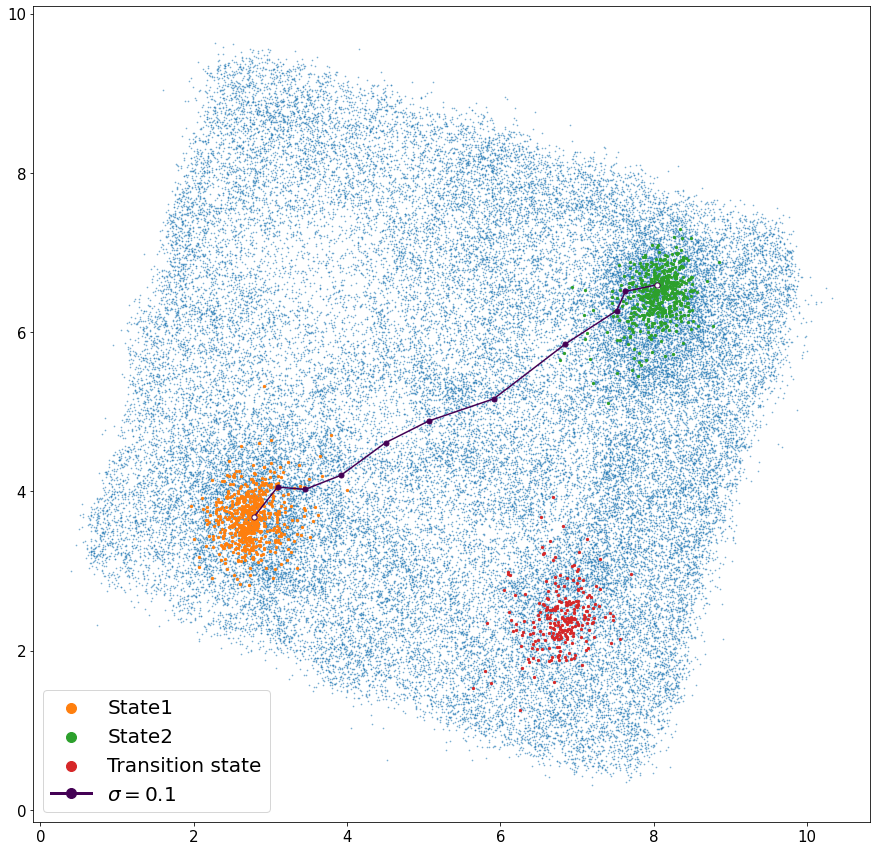

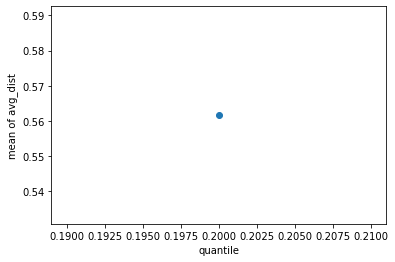

In [14]:
plot_searching_results(emb=dens_emb, 
                       labels=[state1, state2, transition_state], 
                       centers=[center1, center2, transition],
                       paths=toy_paths,
                       quantile_list=toy_quantiles, bandwidth=0.1)

save_the_best_threshold(ndist, toy_paths, toy_quantiles, pathdir=pathdir, eng=True, plot=True, bandwidth=0.1)

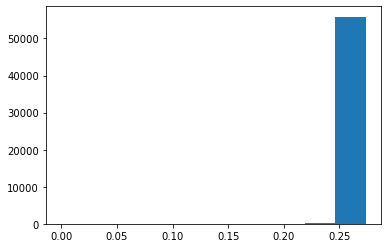

In [15]:
plt.hist(eng);

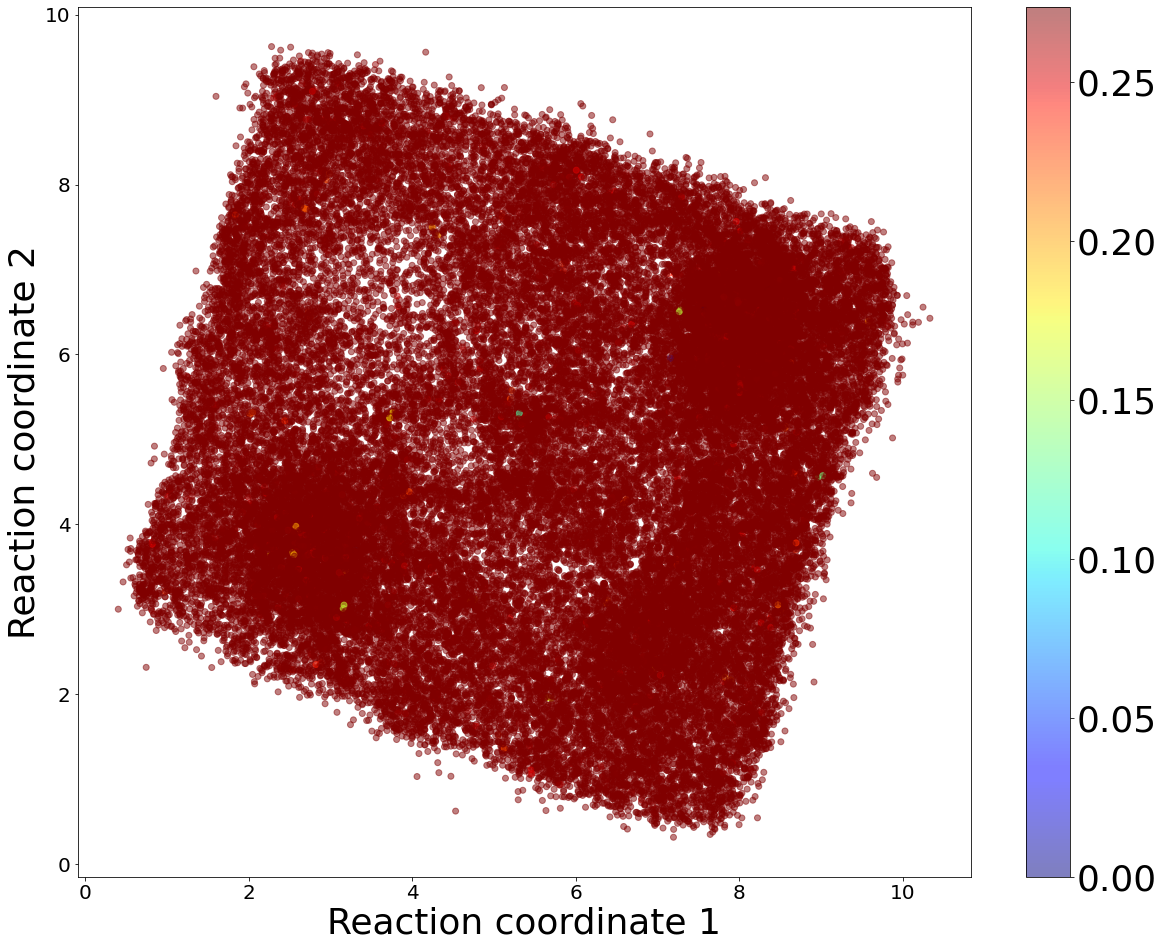

In [16]:
plt.figure(figsize=(20,16))
plt.scatter(dens_emb[:,0], dens_emb[:,1], c=eng, cmap='jet', alpha=0.5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=36)
plt.xlabel("Reaction coordinate 1", fontsize=36)
plt.ylabel("Reaction coordinate 2", fontsize=36)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### Bandwidth = 0.5

In [17]:
ndist, neighbors = construct_grpah(z, max_neighbors=50)
toy_quantiles = [0.2]
toy_paths, eng = energy_weights_searching(ndist, neighbors, bandwidth=0.5,
                                     quantile_list=toy_quantiles, anchors=[center1, center2])

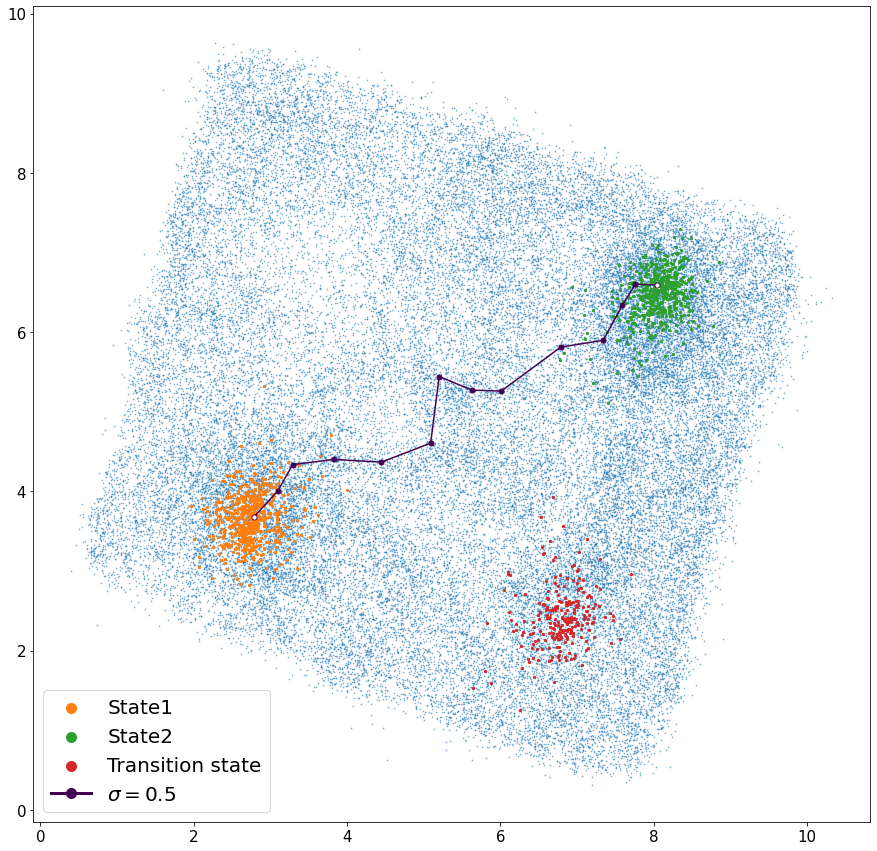

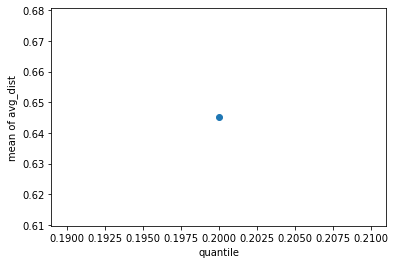

In [18]:
plot_searching_results(emb=dens_emb, 
                       labels=[state1, state2, transition_state], 
                       centers=[center1, center2, transition],
                       paths=toy_paths,
                       quantile_list=toy_quantiles, bandwidth=0.5)

save_the_best_threshold(ndist, toy_paths, toy_quantiles, pathdir=pathdir, eng=True, plot=True, bandwidth=0.5)

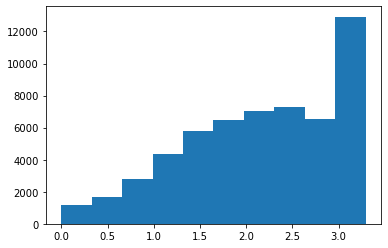

In [19]:
plt.hist(eng);

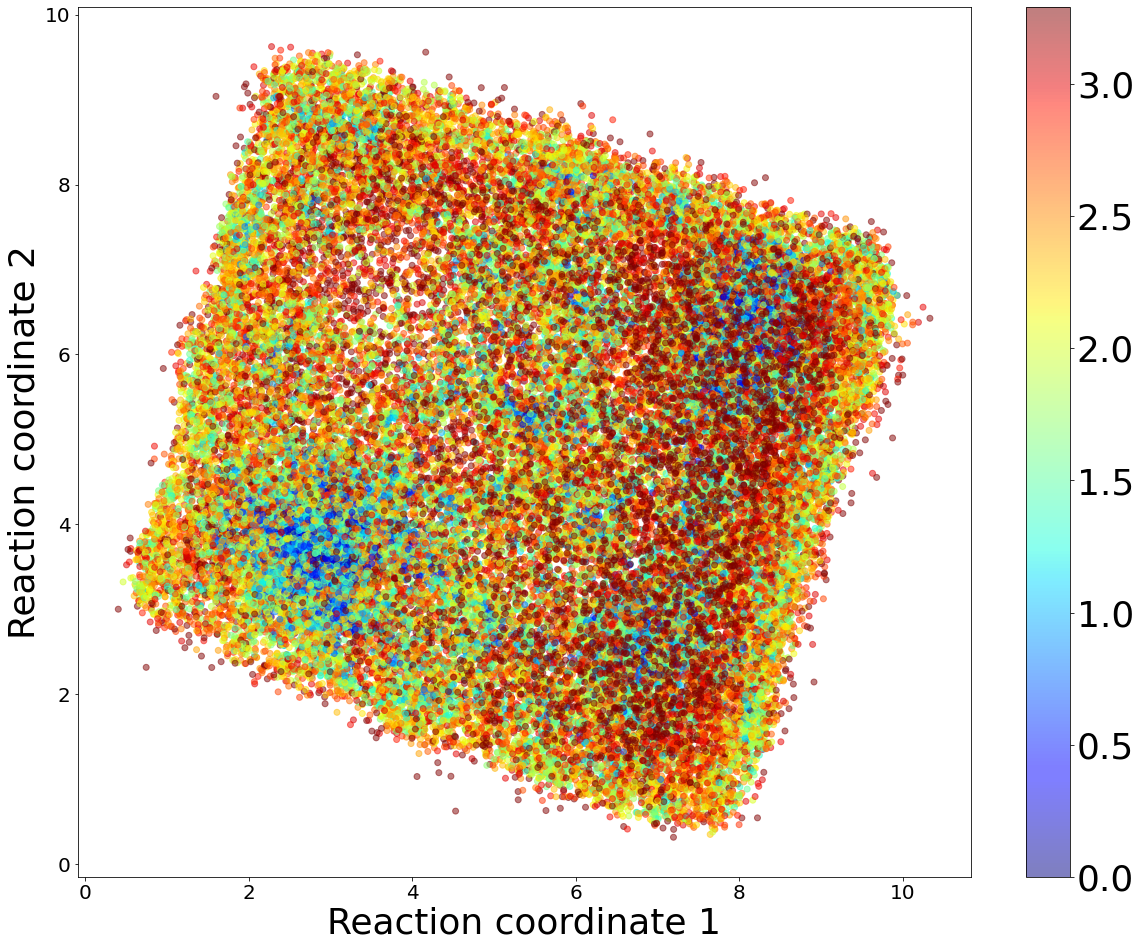

In [20]:
plt.figure(figsize=(20,16))
plt.scatter(dens_emb[:,0], dens_emb[:,1], c=eng, cmap='jet', alpha=0.5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=36)
plt.xlabel("Reaction coordinate 1", fontsize=36)
plt.ylabel("Reaction coordinate 2", fontsize=36)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### Bandwidth = 5

In [21]:
ndist, neighbors = construct_grpah(z, max_neighbors=50)
toy_quantiles = [0.2]
toy_paths, eng = energy_weights_searching(ndist, neighbors, bandwidth=5,
                                     quantile_list=toy_quantiles, anchors=[center1, center2])

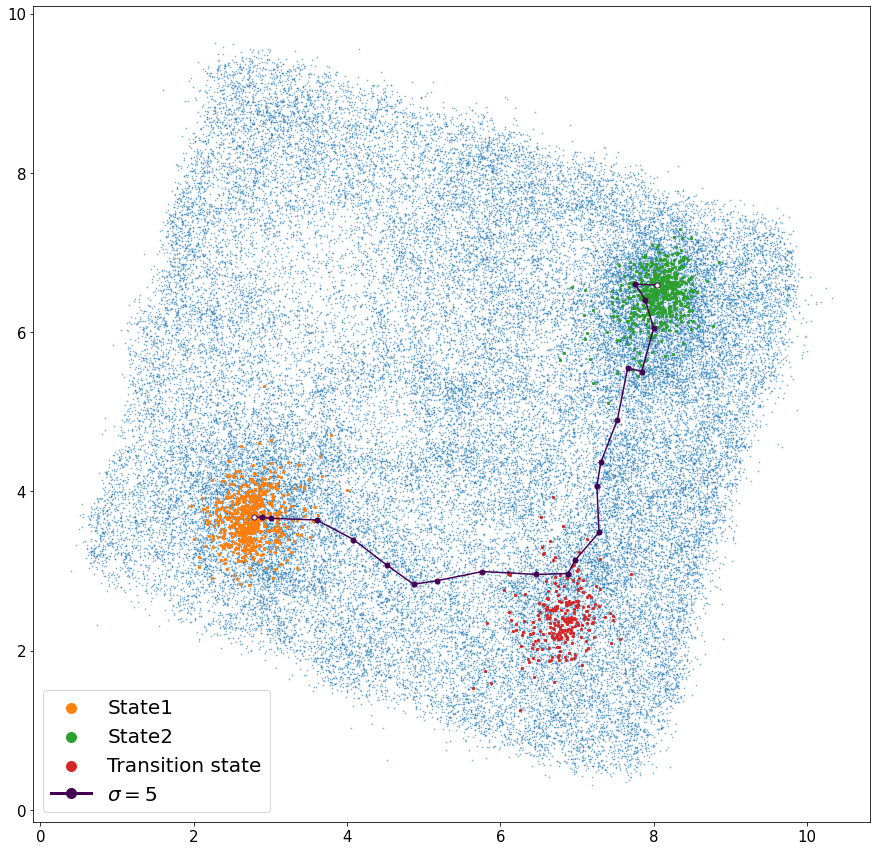

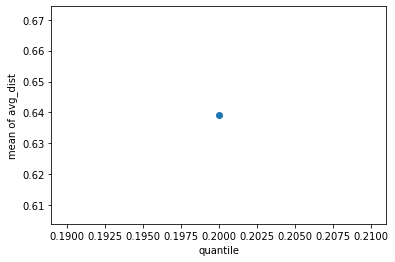

In [22]:
plot_searching_results(emb=dens_emb, 
                       labels=[state1, state2, transition_state], 
                       centers=[center1, center2, transition],
                       paths=toy_paths,
                       quantile_list=toy_quantiles, bandwidth=5)

save_the_best_threshold(ndist, toy_paths, toy_quantiles, pathdir=pathdir, eng=True, plot=True, bandwidth=5)

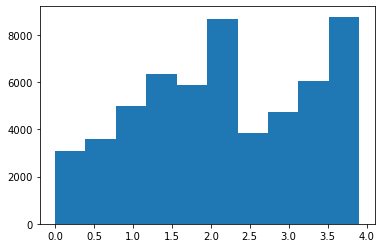

In [23]:
plt.hist(eng);

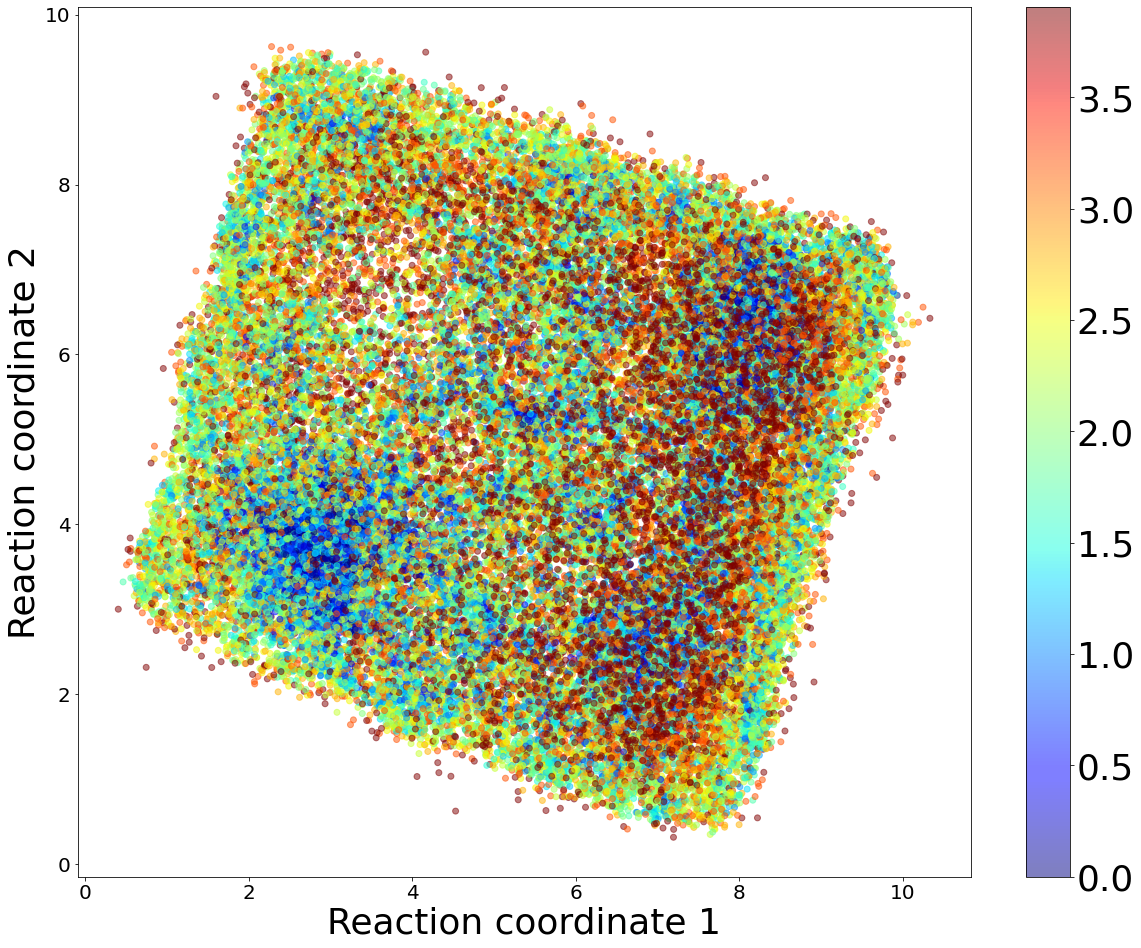

In [24]:
plt.figure(figsize=(20,16))
plt.scatter(dens_emb[:,0], dens_emb[:,1], c=eng, cmap='jet', alpha=0.5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=36)
plt.xlabel("Reaction coordinate 1", fontsize=36)
plt.ylabel("Reaction coordinate 2", fontsize=36)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### Original

In [25]:
ndist, neighbors = construct_grpah(z, max_neighbors=50)
toy_quantiles = [0.2]
toy_paths, eng = energy_weights_searching(ndist, neighbors, bandwidth=-1,
                                     quantile_list=toy_quantiles, anchors=[center1, center2])

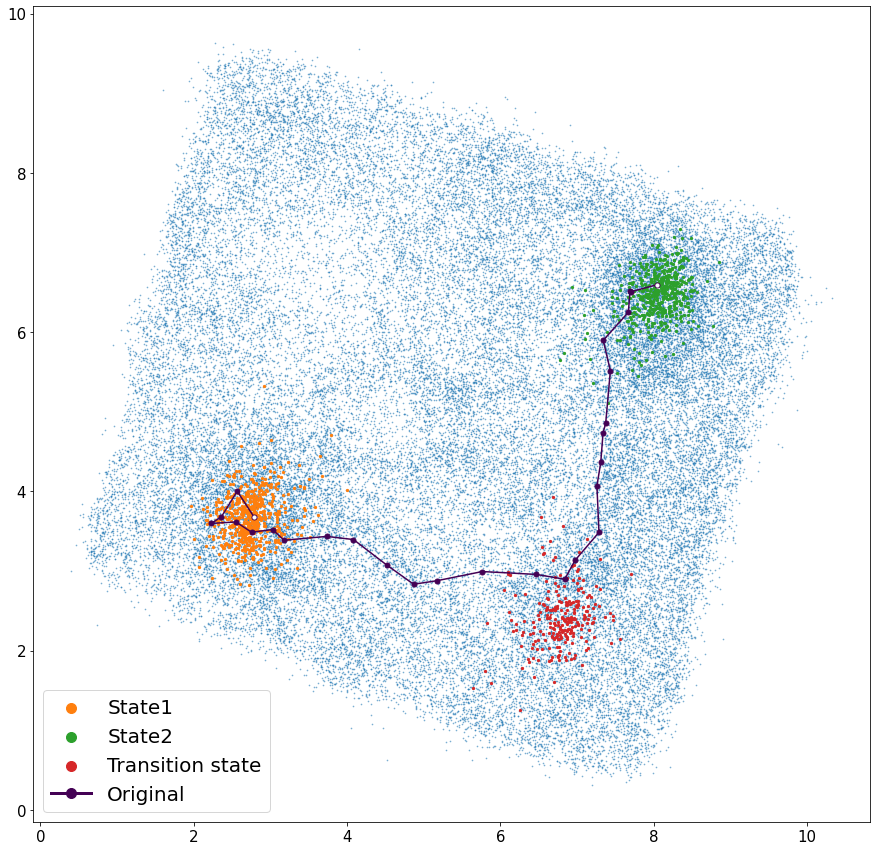

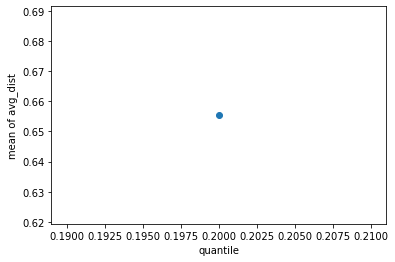

In [26]:
plot_searching_results(emb=dens_emb, 
                       labels=[state1, state2, transition_state], 
                       centers=[center1, center2, transition],
                       paths=toy_paths,
                       quantile_list=toy_quantiles)

save_the_best_threshold(ndist, toy_paths, toy_quantiles, pathdir=pathdir, eng=True, plot=True)

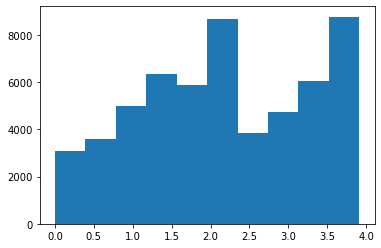

In [27]:
plt.hist(eng);

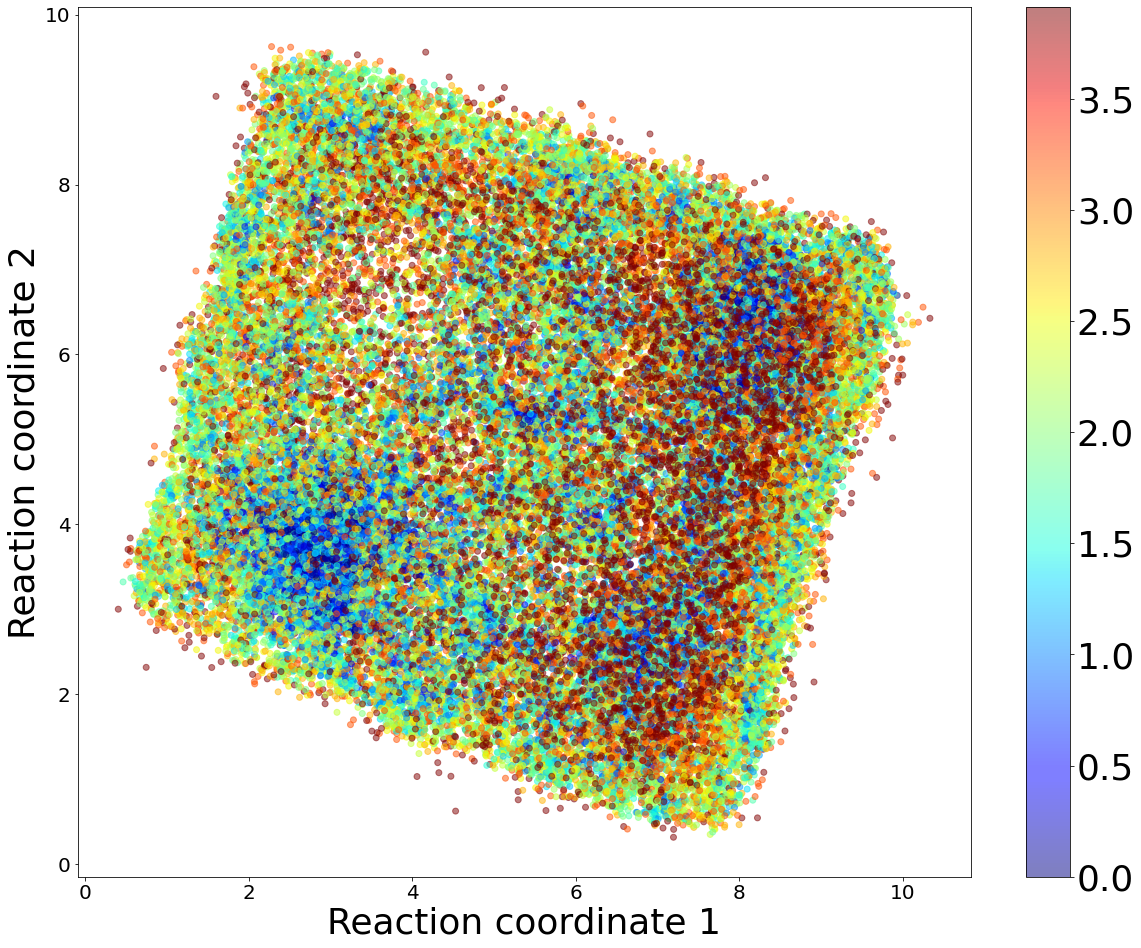

In [28]:
plt.figure(figsize=(20,16))
plt.scatter(dens_emb[:,0], dens_emb[:,1], c=eng, cmap='jet', alpha=0.5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=36)
plt.xlabel("Reaction coordinate 1", fontsize=36)
plt.ylabel("Reaction coordinate 2", fontsize=36)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# Comparsion and Evaulation
First, we generate a 3D volume following the tutorial from cryoDRGN using cryodrgn.analyze. Once the generation is complete, [we calculate the FSC using the same code from cryoDRGN](https://github.com/zhonge/cryodrgn/blob/master/analysis_scripts/fsc.py). Additionally, we evaluate three approaches based on the distance to the ground truth center in the latent space.

In [29]:
# Load results
z = utils.load_pkl(f'{workdir}/z_8/z.49.pkl')
dens_emb = np.load(f'{workdir}/dens_emb.npy')

eng_path1 = np.loadtxt(f'{workdir}/paths/eng_0.1.txt').astype(int)
eng_path2 = np.loadtxt(f'{workdir}/paths/eng_0.5.txt').astype(int)
eng_path3 = np.loadtxt(f'{workdir}/paths/eng_5.txt').astype(int)
eng_path4 = np.loadtxt(f'{workdir}/paths/eng.txt').astype(int)

## Viz

In [30]:
def plot_results(emb, labels, centers, paths):
    '''
    plot the embedding results with the color of each conformational state 
    and the center of each state(black dpt).
    '''
    state_legend = ["Start", "End", "Transition state"]
    state_colors = ['tab:orange', 'tab:green', 'tab:red']
    path_legend = ["$\sigma=0.1$", 
                "$\sigma=0.5$", 
                "$\sigma=5$", 
                "Original "]
    path_colors= ['tab:purple', 'tab:brown', 'tab:gray', 'tab:pink']

    plt.figure(figsize=(10, 8))
    plt.scatter(emb[:, 0], emb[:, 1], s=0.5, alpha=0.25) #densMAP
    for i, state in enumerate(labels):
        plt.scatter(emb[state][:, 0], emb[state][:, 1], s=2, alpha=0.5, c=state_colors[i], zorder=1) #states

    for i, path in enumerate(paths):
        plt.plot(
            emb[path][:, 0], emb[path][:, 1], '-o',
            markersize=5, c=path_colors[i], zorder=2
        ) #paths

    plt.scatter(emb[centers][:, 0], emb[centers][:, 1], s=1, c='w', zorder=3) #white dot for three centers
    plt.xlabel("densMAP 1", fontsize=20)
    plt.ylabel("densMAP 2", fontsize=20)
    plt.show()

    # legend plot
    fig_legend_combined = plt.figure(figsize=(5, 3))  
    axi = fig_legend_combined.add_subplot(111)
    axi.axis('off')
    lines_states = [plt.Line2D([0], [0], color=c, marker='o', linestyle='', markersize=10) for c in state_colors]
    lines_paths = [plt.Line2D([0], [0], color=c, linewidth=2, marker='o', markersize=10) for c in path_colors] 
    combined_lines = lines_states + lines_paths
    combined_labels = state_legend + path_legend
    fig_legend_combined.legend(combined_lines, combined_labels, fontsize=20, loc='center')
    plt.show()

def closest_to_transition(z, path, transition_idx):
    '''
    Find the point in the path which is closest to the transtion state center
    '''
    nearest_point = None
    nearest_distance = float('inf')
    for indx, points in enumerate(z[path]):
        d = distance.euclidean(z[transition_idx], points)
        if d < nearest_distance:
            nearest_point = indx
            nearest_distance = d
    return path[nearest_point], nearest_distance

def plot_cloest_point(emb, points_list):
    '''
    Plot the cloest point with transition state center in embedding space
    '''
    color_list = ['k', 'tab:purple', 'tab:brown', 'tab:gray','tab:pink']
    plt.figure(figsize=(10,8))
    plt.scatter(emb[:,0], emb[:,1], s=0.01)
    for i, point in enumerate(points_list):
        plt.scatter(emb[point, 0], emb[point, 1], s=100, c=color_list[i])
    plt.xlabel("densMAP 1", fontsize=20)
    plt.ylabel("densMAP 2", fontsize=20)
    plt.show()

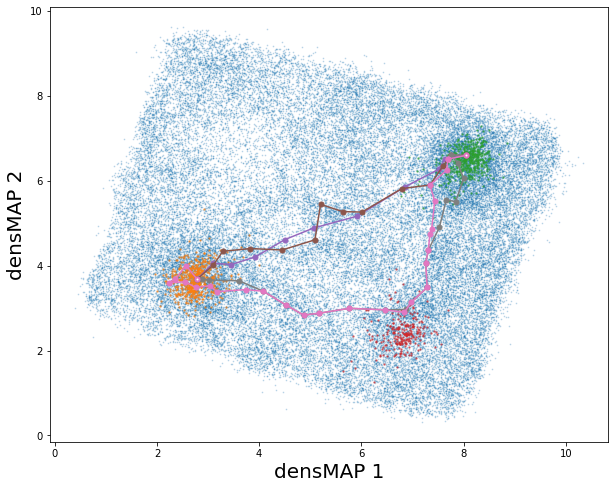

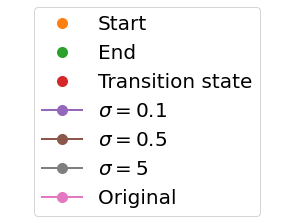

In [31]:
n_PDs = 50
ground_truth_label = get_ground_truth_labels(occ, n_PDs)
state1, state2, transition_state, center1, center2, transition, truth_path = get_centers_and_path(z, ground_truth_label)

plot_results(emb=dens_emb,
             labels=[state1, state2, transition_state],
             centers=[center1, center2, transition],
             paths=[eng_path1, eng_path2, eng_path3, eng_path4])

sigma=0.1 3.2015891075134277 sigma=0.5 3.3141162395477295 sigma=5 0.9484348297119141 original 0.8969053626060486


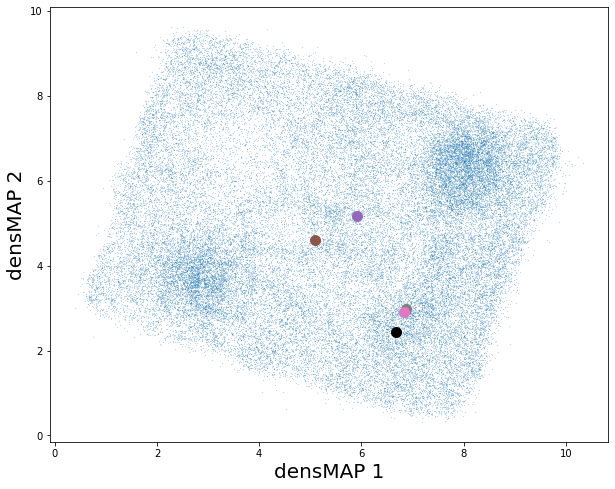

In [32]:
eng_path1_vol_idx, eng_path1_d = closest_to_transition(z, eng_path1, transition)
eng_path2_vol_idx, eng_path2_d = closest_to_transition(z, eng_path2, transition)
eng_path3_vol_idx, eng_path3_d = closest_to_transition(z, eng_path3, transition)
eng_path4_vol_idx, eng_path4_d = closest_to_transition(z, eng_path4, transition)
print("sigma=0.1",eng_path1_d, "sigma=0.5",eng_path2_d, "sigma=5",eng_path3_d, "original", eng_path4_d)
plot_cloest_point(
    dens_emb, 
    [transition, eng_path1_vol_idx, eng_path2_vol_idx, eng_path3_vol_idx, eng_path4_vol_idx]
)

## FSC

In [33]:
def generate_volumes(zvalues, zdir, outdir, **kwargs):
    '''
    Helper function to call cryodrgn eval_vol and generate new volumes
    '''
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    np.savetxt(f'{outdir}/zfile.txt', zvalues)
    analysis.gen_volumes(weights=f'{zdir}/weights.49.pkl',
                         config=f'{zdir}/config.pkl',
                         zfile=f'{outdir}/zfile.txt',
                         outdir=f'{outdir}', **kwargs)
    return print(f'vol in {outdir}/')

def cal_fsc(vol1, vol2):
    '''
    Calculate fsc.
    (From cryoDRGN)
    '''
    D = vol1.shape[0]
    x = np.arange(-D // 2, D // 2)
    x2, x1, x0 = np.meshgrid(x, x, x, indexing="ij")
    coords = np.stack((x0, x1, x2), -1)
    r = (coords**2).sum(-1) ** 0.5

    assert r[D // 2, D // 2, D // 2] == 0.0

    vol1 = fft.fftn_center(vol1)
    vol2 = fft.fftn_center(vol2)

    prev_mask = np.zeros((D, D, D), dtype=bool)
    fsc = [1.0]
    for i in range(1, D // 2):
        mask = r < i
        shell = np.where(mask & np.logical_not(prev_mask))
        v1 = vol1[shell]
        v2 = vol2[shell]
        p = np.vdot(v1, v2) / (np.vdot(v1, v1) * np.vdot(v2, v2)) ** 0.5
        fsc.append(float(p.real))
        prev_mask = mask
    fsc = np.asarray(fsc)
    x = np.arange(D // 2) / D

    res = np.stack((x, fsc), 1)
    return res

def cal_resolution(fsc, threshold=0.5):
    idx = np.abs(fsc[:,1] - threshold).argmin()
    return 1/fsc[idx,0]

def plot_fsc_comparsion(x, fsc_list):
    plt.figure(figsize=(20,16))
    color_list = ['k', 'tab:purple', 'tab:brown', 'tab:gray', 'tab:pink']
    for i, fsc in enumerate(fsc_list):
        plt.plot(x, fsc, c=color_list[i], linewidth=4)
    plt.axvline(x = 0.2, color = 'k', linestyle = '--', linewidth=4)
    plt.xlabel("Frequency", fontsize=40)
    plt.ylabel("FSC", fontsize=40)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.show()

In [34]:
generate_volumes(zvalues=z[[transition, eng_path1_vol_idx, eng_path2_vol_idx, eng_path3_vol_idx, eng_path4_vol_idx]],
                 zdir=f'{workdir}/z_8',
                 outdir=f'{workdir}/vols_kernel/',
                 Apix = 1)

2023-09-01 15:30:46.418154     Namespace(weights='/home/phonchi/energy_aware_pathfinding/energy_aware_pathfinding-main/energy_aware_pathfinding-main/hsp90//z_8/weights.49.pkl', config='/home/phonchi/energy_aware_pathfinding/energy_aware_pathfinding-main/energy_aware_pathfinding-main/hsp90//z_8/config.pkl', o='/home/phonchi/energy_aware_pathfinding/energy_aware_pathfinding-main/energy_aware_pathfinding-main/hsp90/vols_kernel', prefix='vol_', device=None, verbose=False, z=None, z_start=None, z_end=None, n=10, zfile='/home/phonchi/energy_aware_pathfinding/energy_aware_pathfinding-main/energy_aware_pathfinding-main/hsp90//vols_kernel//zfile.txt', Apix=1.0, flip=False, invert=False, downsample=None, vol_start_index=0, norm=None, D=None, qlayers=None, qdim=None, zdim=None, encode_mode=None, players=None, pdim=None, enc_mask=None, pe_type=None, feat_sigma=None, pe_dim=None, domain=None, l_extent=None, activation='relu')
2023-09-01 15:30:46.419220     Loaded configuration:
{'dataset_args': {'c

In [35]:
vol_truth, _ = mrc.parse_mrc(f'{workdir}/vols/state_15_05_1.mrc')
vol_center, _ = mrc.parse_mrc(f'{workdir}/vols_kernel/vol_000.mrc')
vol_eng1, _ = mrc.parse_mrc(f'{workdir}/vols_kernel/vol_001.mrc')
vol_eng2, _ = mrc.parse_mrc(f'{workdir}/vols_kernel/vol_002.mrc')
vol_eng3, _ = mrc.parse_mrc(f'{workdir}/vols_kernel/vol_003.mrc')
vol_eng4, _ = mrc.parse_mrc(f'{workdir}/vols_kernel/vol_004.mrc')

fsc_center = cal_fsc(vol_truth, vol_center)
fsc_eng1 = cal_fsc(vol_truth, vol_eng1)
fsc_eng2 = cal_fsc(vol_truth, vol_eng2)
fsc_eng3 = cal_fsc(vol_truth, vol_eng3)
fsc_eng4 = cal_fsc(vol_truth, vol_eng4)

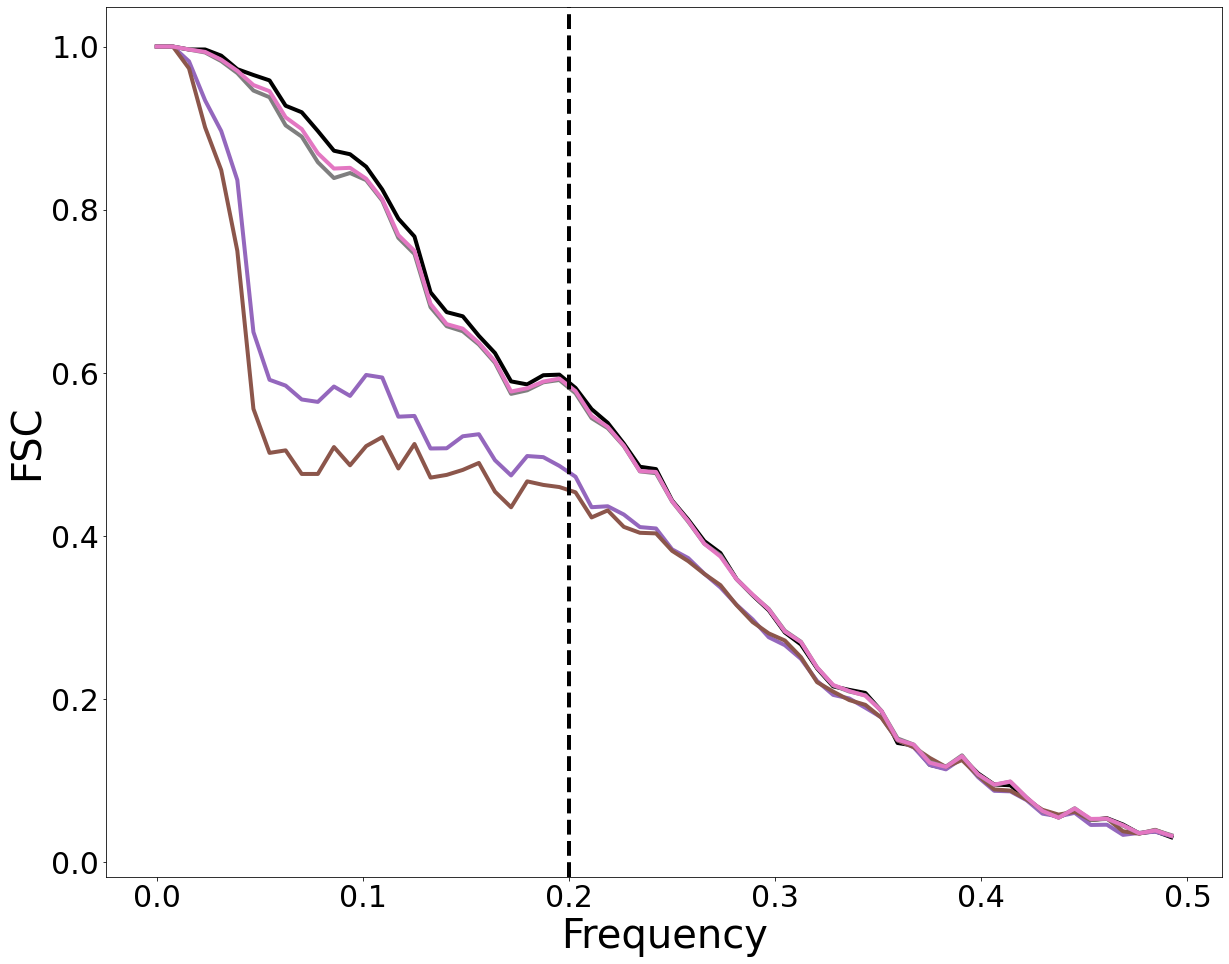

In [36]:
plot_fsc_comparsion(x=fsc_center[:,0],
                    fsc_list=[fsc_center[:,1], fsc_eng1[:,1], fsc_eng2[:,1], fsc_eng3[:,1], fsc_eng4[:,1]])

In [37]:
freq = fsc_center[:,0]
difference_array = np.absolute(freq-0.2) #5A
index = difference_array.argmin()

In [38]:
print("Label center:", fsc_center[index,1])
print("sigma=0.1:", fsc_eng1[index,1])
print("sigma=0.5:", fsc_eng2[index,1])
print("sigma=5:", fsc_eng3[index,1])
print("Original:", fsc_eng4[index,1])

Label center: 0.5816358577008858
sigma=0.1: 0.47277034481170205
sigma=0.5: 0.4536880732109347
sigma=5: 0.575079170708865
Original: 0.5778017148631214


## Distances

In [39]:
def ave_distance(z, truth, path):
    dis = []
    for i in truth:
        _, d = closest_to_transition(z, path, i)
        dis.append(d)
    return sum(dis)/(len(truth)-2)
    
def sum_distance(z, truth, path):
    dis = []
    for i in truth:
        _, d = closest_to_transition(z, path, i)
        dis.append(d)
    return sum(dis)

def hausdorff_distance(set1, set2):
  # Initialize maximum distance to 0
  max_distance_1 = 0
  
  # Iterate through points in set1
  for point1 in set1:
    # Find nearest point in set2
    nearest_point = None
    nearest_distance = float('inf')
    for point2 in set2:
      d = distance.euclidean(point1, point2)
      if d < nearest_distance:
        nearest_point = point2
        nearest_distance = d
    # Update maximum distance if necessary
    max_distance_1 = max(max_distance_1, nearest_distance)
  
  max_distance_2 = 0

  for point2 in set2:
    nearest_point = None
    nearest_distance = float('inf')

    for point1 in set1:
      d = distance.euclidean(point1, point2)
      if d < nearest_distance:
        nearest_point = point1
        nearest_distance = d
    
    max_distance_2 = max(max_distance_2, nearest_distance)

  max_distance = max(max_distance_1, max_distance_2)
  return max_distance

In [40]:
print("sigma=0.1:",ave_distance(z, truth_path, eng_path1))
print("sigma=0.5:",ave_distance(z, truth_path, eng_path2))
print("sigma=5:",ave_distance(z, truth_path, eng_path3))
print("Original:",ave_distance(z, truth_path, eng_path4))

sigma=0.1: 2.2001798493521556
sigma=0.5: 2.1184546379815963
sigma=5: 0.6478337645530701
Original: 0.6284189309392657


In [41]:
print("sigma=0.1:",hausdorff_distance(z[truth_path], z[eng_path1]))
print("sigma=0.5:",hausdorff_distance(z[truth_path], z[eng_path2]))
print("sigma=5:",hausdorff_distance(z[truth_path], z[eng_path3]))
print("Original:",hausdorff_distance(z[truth_path], z[eng_path4]))

sigma=0.1: 3.2015891075134277
sigma=0.5: 3.3141162395477295
sigma=5: 1.1384880542755127
Original: 1.2141095399856567
